In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

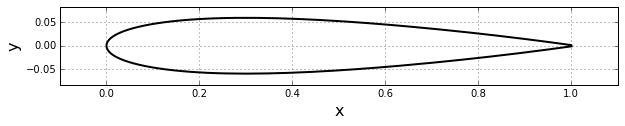

In [2]:
# reads of the geometry from a data file
with open ('./resources/naca0012.dat') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plots the geometry
%matplotlib inline

val_x, val_y = 0.1, 0.2
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2);

In [3]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [4]:
def define_panels(x, y, N=40):
    """Discretizes the geometry into panels using 'cosine' method.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the geometry (1D arrays).
    N - number of panels (default 40).
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    R = (x.max()-x.min())/2                                    # radius of the circle
    x_center = (x.max()+x.min())/2                             # x-coord of the center
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  # x-coord of the circle points
    
    x_ends = numpy.copy(x_circle)      # projection of the x-coord on the surface
    y_ends = numpy.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

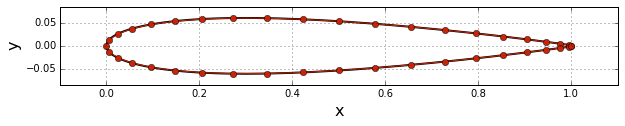

In [5]:
N = 40                            # number of panels
panels = define_panels(x, y, N)   # discretizes of the geometry into panels

# plots the geometry and the panels
val_x, val_y = 0.1, 0.2
x_min, x_max = min(panel.xa for panel in panels), max(panel.xa for panel in panels)
y_min, y_max = min(panel.ya for panel in panels), max(panel.ya for panel in panels)
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
         numpy.append([panel.ya for panel in panels], panels[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');

In [6]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf=1.0, alpha=0.0):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [7]:
# defines and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

In [8]:
def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

In [9]:
def build_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+1)x1, N is the number of panels).
    """
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [10]:
A = build_matrix(panels)	                    # computes the singularity matrix
b = build_rhs(panels, freestream)               # computes the freestream RHS

In [11]:
# solves the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
	panel.sigma = sigma[i]

In [12]:
def get_tangential_velocity(panels, freestream):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [13]:
# computes the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream)

In [14]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [15]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

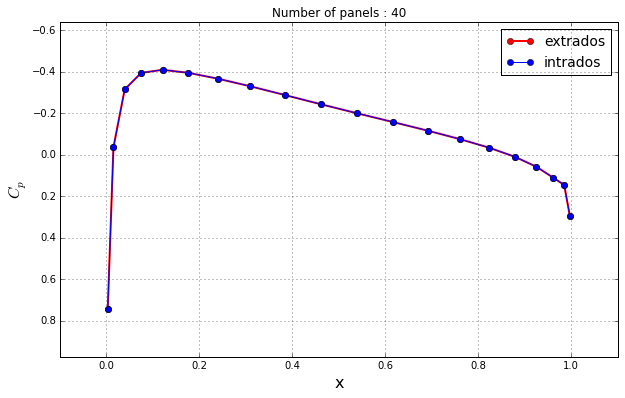

In [16]:
# plots the surface pressure coefficient
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
cp_min, cp_max = min( panel.cp for panel in panels ), max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'extrados'], 
         [panel.cp for panel in panels if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'intrados'], 
         [panel.cp for panel in panels if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels : %d' % N);

In [17]:
# calculates the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print '--> sum of source/sink strengths:', accuracy

--> sum of source/sink strengths: 0.00461703117528


In [18]:
def get_velocity_field(panels, freestream, X, Y):
    """Returns the velocity field.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    X, Y -- mesh grid.
    """
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in xrange(Nx):
        for j in xrange(Ny):
            u[i,j] = freestream.u_inf*math.cos(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
            v[i,j] = freestream.u_inf*math.sin(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
    
    return u, v

In [19]:
# defines a mesh grid
Nx, Ny = 20, 20                  # number of points in the x and y directions
val_x, val_y = 1.0, 2.0
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
y_min, y_max = min( panel.ya for panel in panels ), max( panel.ya for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, Nx), numpy.linspace(y_start, y_end, Ny))

# computes the velicity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

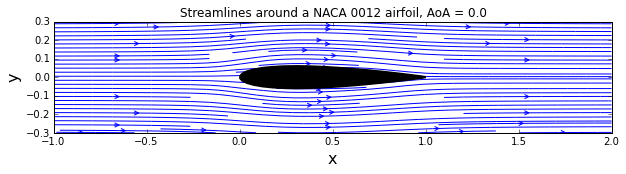

In [20]:
# plots the velocity field
size=10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels], 
         [panel.yc for panel in panels], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Streamlines around a NACA 0012 airfoil, AoA = %.1f' % alpha);

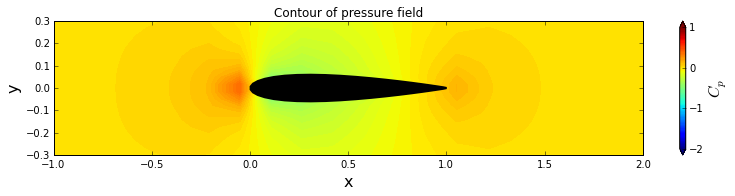

In [22]:
# computes the pressure field
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plots the pressure field
size=12
pyplot.figure(figsize=(1.1*size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp, levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])
pyplot.fill([panel.xc for panel in panels], 
         [panel.yc for panel in panels], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Contour of pressure field');